# Monkeys Species Classification Project
 
We want to train a model that can tell the difference between 10 types of Monkeys

To do this we are going to use a famous Imagenet model called InceptionV3 to do transfer Learning.

Along the way will also use the new tf.data along with Pandas to handle the input pipelines for training and testing.

This project can be customized to a variety of different image datasets. Here ia another you could try:

Monkeys  - https://www.dropbox.com/s/je25ylpp8r1r8uc/10-monkey-species.zip


## Testing for GPU 


To Test if you have GPU set up

Run the Cell below

if no GPU is found press Runtime (in the menu at the top) and choose "Change Runtime Type" to GPU

In [187]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Download the data

by placing ! infront we can run almost any linux shell command

In [188]:
!ls

checkpoint			 monkeys1_tf.index
checkpoints			 monkeys1_weights.h5
flowers				 __pycache__
flowers.h5			 sample_data
flowers_tf.data-00000-of-00001	 sutils.py
flowers_tf.index		 testing_flowers
flowers_weights.h5		 training
gdrive.py			 training.zip
__MACOSX			 utils.zip
monkey_labels.txt		 utils.zip.1
monkeys1.h5			 validation
monkeys1_tf.data-00000-of-00001  validation.zip


In [1]:
!wget -qq https://www.dropbox.com/s/vj61417lofjebju/utils.zip
#!wget -qq https://www.dropbox.com/s/pcv5wpk0ybsohib/flowers.zip
#!wget -qq https://www.dropbox.com/s/je25ylpp8r1r8uc/10-monkey-species.zip
  
  
#!unzip -qq flowers.zip
#!rm flowers.zip

!unzip -qq training.zip
!unzip -qq validation.zip
#!rm 10-monkey-species.zip

#!unzip -qq utils.zip
#!rm utils.zip


!ls

checkpoint			gdrive.py	   training
checkpoints			__MACOSX	   training.zip
flowers				monkey_labels.txt  utils.zip
flowers.h5			__pycache__	   utils.zip.1
flowers_tf.data-00000-of-00001	sample_data	   validation
flowers_tf.index		sutils.py	   validation.zip
flowers_weights.h5		testing_flowers


In [2]:
!pwd


/content


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt


from sutils import *
import os, json
from glob import glob
import numpy as np

import keras

from tensorflow.keras import optimizers

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16


from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from tensorflow.python.keras.models import Model,load_model,Sequential

from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.python.keras import backend as K

from tensorflow.keras.callbacks import ModelCheckpoint, Callback




In [190]:
print(tf.__version__)
print(tf.keras.__version__)
print(keras.__version__)

1.12.0
2.1.6-tf
2.2.4


In [191]:


!ls flowers

!ls training

daisy  dandelion  rose	sunflower  tulip
n0  n1	n2  n3	n4  n5	n6  n7	n8  n9


In [0]:
# Set up some Hyperparameters

batch_size = 32
epochs = 10

lr = 0.001

## Converting raw files in folders into something we can feed into tf.data

We use glob to get lists of the files in the directories and then convert them into dataframes and add in class numbers.

We also then split them up so we have 10% for a testing set and the rest for training.

finally we randomly shuffle them up



In [193]:
import glob
import pandas as pd

filenames_n0 = glob.glob('./training/n0/*.jpg')
filenames_n1 = glob.glob('./training/n1/*.jpg')
filenames_n2 = glob.glob('./training/n2/*.jpg')
filenames_n3 = glob.glob('./training/n3/*.jpg')
filenames_n4 = glob.glob('./training/n4/*.jpg')
filenames_n5 = glob.glob('./training/n5/*.jpg')
filenames_n6 = glob.glob('./training/n6/*.jpg')
filenames_n7 = glob.glob('./training/n7/*.jpg')
filenames_n8 = glob.glob('./training/n8/*.jpg')
filenames_n9 = glob.glob('./training/n9/*.jpg')
 

#names = ['daisy', 'dandelion','rose','sunflower','tulip']

names = ['alouatta', 'erythro','cacaujao','macaca','cebeuella','cebus', 'mico', 'saimiri', 'aotus','trachy']

print(len(filenames_n0))
print(len(filenames_n1))
print(len(filenames_n2))
print(len(filenames_n3))
print(len(filenames_n4))
print(len(filenames_n5))
print(len(filenames_n6))
print(len(filenames_n7))
print(len(filenames_n8))
print(len(filenames_n9))

print(names)

105
111
110
122
105
113
106
114
106
104
['alouatta', 'erythro', 'cacaujao', 'macaca', 'cebeuella', 'cebus', 'mico', 'saimiri', 'aotus', 'trachy']


In [194]:
filenames_n8[:10]

['./training/n8/n8063.jpg',
 './training/n8/n8039.jpg',
 './training/n8/n8070.jpg',
 './training/n8/n8032.jpg',
 './training/n8/n8071.jpg',
 './training/n8/n8030.jpg',
 './training/n8/n8125.jpg',
 './training/n8/n8051.jpg',
 './training/n8/n8067.jpg',
 './training/n8/n8138.jpg']

In [0]:
# Make a dataframe based on the filenames
df = pd.DataFrame(filenames_n0, columns = ["filename"])
df2 = pd.DataFrame(filenames_n1, columns = ["filename"])
df3 = pd.DataFrame(filenames_n2, columns = ["filename"])
df4 = pd.DataFrame(filenames_n3, columns = ["filename"])
df5 = pd.DataFrame(filenames_n4, columns = ["filename"])
df6 = pd.DataFrame(filenames_n5, columns = ["filename"])
df7 = pd.DataFrame(filenames_n6, columns = ["filename"])
df8 = pd.DataFrame(filenames_n7, columns = ["filename"])
df9 = pd.DataFrame(filenames_n8, columns = ["filename"])
df10 = pd.DataFrame(filenames_n9, columns = ["filename"])


# Add Class columns 
df['class'] = pd.Series([0 for x in range(len(df.index))], index=df.index)
df2['class'] = pd.Series([1 for x in range(len(df2.index))], index=df2.index)
df3['class'] = pd.Series([2 for x in range(len(df3.index))], index=df3.index)
df4['class'] = pd.Series([3 for x in range(len(df4.index))], index=df4.index)
df5['class'] = pd.Series([4 for x in range(len(df5.index))], index=df5.index)
df6['class'] = pd.Series([5 for x in range(len(df6.index))], index=df6.index)
df7['class'] = pd.Series([6 for x in range(len(df7.index))], index=df7.index)
df8['class'] = pd.Series([7 for x in range(len(df8.index))], index=df8.index)
df9['class'] = pd.Series([8 for x in range(len(df9.index))], index=df9.index)
df10['class'] = pd.Series([9 for x in range(len(df10.index))], index=df10.index)


# Split into train and validation sets
train_set_percentage = .9


train_df = df[:int(len(df)*train_set_percentage)]
val_df = df[int(len(df)*train_set_percentage):]

train_df2 = df2[:int(len(df2)*train_set_percentage)]
val_df2 = df2[int(len(df2)*train_set_percentage):]

train_df3 = df3[:int(len(df3)*train_set_percentage)]
val_df3 = df3[int(len(df3)*train_set_percentage):]

train_df4 = df4[:int(len(df4)*train_set_percentage)]
val_df4 = df4[int(len(df4)*train_set_percentage):]

train_df5 = df5[:int(len(df5)*train_set_percentage)]
val_df5 = df5[int(len(df5)*train_set_percentage):]


train_df6 = df6[:int(len(df6)*train_set_percentage)]
val_df6 = df6[int(len(df6)*train_set_percentage):]

train_df7 = df7[:int(len(df7)*train_set_percentage)]
val_df7 = df7[int(len(df7)*train_set_percentage):]

train_df8 = df8[:int(len(df8)*train_set_percentage)]
val_df8 = df8[int(len(df8)*train_set_percentage):]

train_df9 = df9[:int(len(df9)*train_set_percentage)]
val_df9 = df9[int(len(df9)*train_set_percentage):]

train_df10 = df10[:int(len(df10)*train_set_percentage)]
val_df10 = df10[int(len(df10)*train_set_percentage):]




df_new_train = pd.concat([train_df, train_df2, train_df3, train_df4, train_df5,train_df6, train_df7, train_df8, train_df9, train_df10])
df_new_val = pd.concat([val_df, val_df2, val_df3, val_df4, val_df5,val_df6, val_df7, val_df8, val_df9, val_df10])
# Shuffle
df = df_new_train.sample(frac=1).reset_index(drop=True)
df_val = df_new_val.sample(frac=1).reset_index(drop=True)

# Examine the Dataset

lets look at what we have now. 

In [196]:
df.head()

,filename,class
0,./training/n4/n4129.jpg,4
1,./training/n9/n9147.jpg,9
2,./training/n7/n7062.jpg,7
3,./training/n9/n9055.jpg,9
4,./training/n7/n7067.jpg,7


In [197]:
print(df.shape)
print(df_val.shape)

df['class'].unique()

(981, 2)
(115, 2)


array([4, 9, 7, 3, 5, 6, 1, 8, 0, 2])

3    109
7    102
5    101
2     99
1     99
8     95
6     95
4     94
0     94
9     93
Name: class, dtype: int64


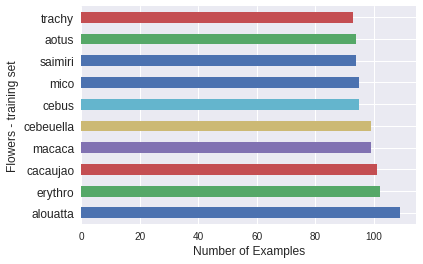

In [198]:
print(df['class'].value_counts())


ax = df['class'].value_counts().plot.barh()
ax.set_xlabel("Number of Examples", fontsize=12)
ax.set_ylabel("Flowers - training set", fontsize=12)
ax.set_yticklabels(['alouatta', 'erythro','cacaujao','macaca','cebeuella','cebus', 'mico', 'saimiri', 'aotus','trachy'], rotation=0, fontsize=12)
plt.show()

In [0]:
# convert the dataframe into 2 lists to use for filename and labels
train_filenames_list = df["filename"].tolist()
train_labels_list = df["class"].astype('int32').tolist()

# convert the dataframe into 2 lists to use for filename and labels
val_filenames_list = df_val["filename"].tolist()
val_labels_list = df_val["class"].astype('int32').tolist()

#number of classes #originally 5
num_classes = 10



In [260]:
len(val_labels_list)
len(train_labels_list)

981

In [0]:
# Split into train and validation sets
# train_set_percentage = .9

# # Make the training set
# train_filenames_list = filenames_list[:int(len(filenames_list)*train_set_percentage)]
# train_labels_list = labels_list[:int(len(filenames_list)*train_set_percentage)]

# # Make the validation set
# val_filenames_list = filenames_list[int(len(filenames_list)*train_set_percentage):]
# val_labels_list = labels_list[int(len(filenames_list)*train_set_percentage):]


## Make the pipeline for loading and resizing the images

In [0]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 299,299

def _parse_function(filename, label):
  image_string = tf.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string)
  image_resized = tf.image.resize_images(image_decoded, [img_rows, img_cols])
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [0]:
# A vector of filenames - from a list
filenames = tf.constant(train_filenames_list)

# Labels that match the training files - from a list
labels = tf.constant(train_labels_list)

# Same as above but for validation set
val_filenames = tf.constant(val_filenames_list)
val_labels = tf.constant(val_labels_list)

## Assembling the Data pipeline using tf.data

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.repeat(30)
train_dataset = train_dataset.batch(32)

In [0]:
valid_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.repeat(30)
valid_dataset = valid_dataset.batch(32)

In [0]:
test_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.repeat(30)
test_dataset = test_dataset.batch(32)

## Chosing the pre-trained network for Transfer Learning




https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels.h5

https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [0]:
# InceptionV3 Model - trained on image net
base_model = InceptionV3(weights='imagenet', include_top=False)

# VGG16 Model - trained on image net
#base_model = VGG16(weights='imagenet', include_top=False)


In [206]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, None, None, 3 96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, None, None, 3 0           batch_normalization_282[0][0]    
__________________________________________________________________________________________________
conv2d_283

## Create a simple head for the model that we can train

In [0]:

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)


# 5 Classes for flowers
predictions = Dense(num_classes, activation='softmax')(x)


In [208]:
predictions

<tf.Tensor 'dense_7/Softmax:0' shape=(?, 10) dtype=float32>

In [0]:
# Creating the model that we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [210]:
# Freeze the InceptionV3 layers except the BatchNorm
for layer in base_model.layers:
    if 'batch' in layer.name:
      print(layer.name)
      layer.trainable = True
    else:
      layer.trainable = False 


batch_normalization_282
batch_normalization_283
batch_normalization_284
batch_normalization_285
batch_normalization_286
batch_normalization_290
batch_normalization_288
batch_normalization_291
batch_normalization_287
batch_normalization_289
batch_normalization_292
batch_normalization_293
batch_normalization_297
batch_normalization_295
batch_normalization_298
batch_normalization_294
batch_normalization_296
batch_normalization_299
batch_normalization_300
batch_normalization_304
batch_normalization_302
batch_normalization_305
batch_normalization_301
batch_normalization_303
batch_normalization_306
batch_normalization_307
batch_normalization_309
batch_normalization_310
batch_normalization_308
batch_normalization_311
batch_normalization_316
batch_normalization_317
batch_normalization_313
batch_normalization_318
batch_normalization_314
batch_normalization_319
batch_normalization_312
batch_normalization_315
batch_normalization_320
batch_normalization_321
batch_normalization_326
batch_normalizat

In [211]:
for layer in model.layers:
    print(layer.name)
    print(layer.trainable)

input_4
False
conv2d_282
False
batch_normalization_282
True
activation_282
False
conv2d_283
False
batch_normalization_283
True
activation_283
False
conv2d_284
False
batch_normalization_284
True
activation_284
False
max_pooling2d_12
False
conv2d_285
False
batch_normalization_285
True
activation_285
False
conv2d_286
False
batch_normalization_286
True
activation_286
False
max_pooling2d_13
False
conv2d_290
False
batch_normalization_290
True
activation_290
False
conv2d_288
False
conv2d_291
False
batch_normalization_288
True
batch_normalization_291
True
activation_288
False
activation_291
False
average_pooling2d_27
False
conv2d_287
False
conv2d_289
False
conv2d_292
False
conv2d_293
False
batch_normalization_287
True
batch_normalization_289
True
batch_normalization_292
True
batch_normalization_293
True
activation_287
False
activation_289
False
activation_292
False
activation_293
False
mixed0
False
conv2d_297
False
batch_normalization_297
True
activation_297
False
conv2d_295
False
conv2d_298
F

## Select an Optimizer 

In [0]:
# creates the optimizer using a tensorFlow optimizer with lr setting the Learning Rate

# tf.keras optimizer
opt = optimizers.Adam(lr)

# We could use a TensorFlow Optimizer but they can't save the weight as a whole
# opt = tf.train.AdamOptimizer(lr)

## Compile the model

In [0]:
# compile the model 

model.compile(optimizer= opt, loss='categorical_crossentropy',metrics=['accuracy'])

## Call backs

In [215]:
!mkdir checkpoints


checkpoint = ModelCheckpoint('./checkpoints/weights_{epoch:02d}_{val_acc:.2f}.hdf5', verbose=1, save_best_only=True, mode='auto')

mkdir: cannot create directory ‘checkpoints’: File exists


Steps = 3664 / batch_size

Steps =495/batch_size 

1086 /32

In [0]:
train_steps = 30
val_steps = 10
epochs = 5

## Fit the model

we pass in:
- The training set
- the steps for how many times we want to sample a batch to be one epoch
- number of epochs
- validation set
- number of steps for validation

In [218]:
# # Train the model with validation 
history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[checkpoint])

Epoch 1/5
29/30 [============================>.] - ETA: 2s - loss: 1.1234 - acc: 0.6972
Epoch 00001: val_loss improved from inf to 1.96073, saving model to ./checkpoints/weights_01_0.43.hdf5
30/30 [==============================] - 267s 9s/step - loss: 1.0911 - acc: 0.7063 - val_loss: 1.9607 - val_acc: 0.4344
Epoch 2/5
29/30 [============================>.] - ETA: 1s - loss: 0.1798 - acc: 0.9461
Epoch 00002: val_loss improved from 1.96073 to 0.51817, saving model to ./checkpoints/weights_02_0.87.hdf5
30/30 [==============================] - 47s 2s/step - loss: 0.1776 - acc: 0.9469 - val_loss: 0.5182 - val_acc: 0.8688
Epoch 3/5
29/30 [============================>.] - ETA: 1s - loss: 0.0763 - acc: 0.9774
Epoch 00003: val_loss improved from 0.51817 to 0.07632, saving model to ./checkpoints/weights_03_0.97.hdf5
30/30 [==============================] - 46s 2s/step - loss: 0.0776 - acc: 0.9771 - val_loss: 0.0763 - val_acc: 0.9750
Epoch 4/5
29/30 [============================>.] - ETA: 1s - 

In [128]:
# # Train the model with validation 
history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[checkpoint])

Epoch 1/1
29/30 [============================>.] - ETA: 1s - loss: 0.1521 - acc: 0.9504
Epoch 00001: val_loss improved from 1.64626 to 0.35873, saving model to ./checkpoints/weights_01_0.89.hdf5
30/30 [==============================] - 47s 2s/step - loss: 0.1486 - acc: 0.9521 - val_loss: 0.3587 - val_acc: 0.8938


In [219]:
!ls checkpoints

weights_01_0.11.hdf5  weights_01_1.00.hdf5  weights_03_0.97.hdf5
weights_01_0.43.hdf5  weights_02_0.87.hdf5  weights_04_0.98.hdf5
weights_01_0.51.hdf5  weights_02_0.90.hdf5  weights_05_0.97.hdf5
weights_01_0.88.hdf5  weights_02_0.93.hdf5
weights_01_0.89.hdf5  weights_02_1.00.hdf5


In [0]:
model.load_weights('./checkpoints/weights_05_0.97.hdf5')

In [221]:
metrics = model.evaluate(valid_dataset,steps=10)
print("model accuracy:",metrics[1])

10/10 [==============================] - 9s 908ms/step
model accuracy: 0.971875


In [222]:
test_dataset

<BatchDataset shapes: ((?, 299, 299, ?), (?, 10)), types: (tf.float32, tf.float32)>

## Make some predictions


In [254]:
preds = model.predict(test_dataset,steps=4)
preds = preds.argmax(axis=-1)

preds.shape

(128,)

In [0]:
test_labels = val_labels_list[0:128] #320

In [257]:
len(test_labels)
 

115

## Save the Model and weights 

In [0]:
model.save('monkeys2.h5')


In [0]:
model.save_weights('monkeys2_weights.h5', save_format='h5')

In [232]:
!ls

checkpoint			 monkeys1_weights.h5
checkpoints			 monkeys2.h5
flowers				 monkeys2_weights.h5
flowers.h5			 __pycache__
flowers_tf.data-00000-of-00001	 sample_data
flowers_tf.index		 sutils.py
flowers_weights.h5		 testing_flowers
gdrive.py			 training
__MACOSX			 training.zip
monkey_labels.txt		 utils.zip
monkeys1.h5			 utils.zip.1
monkeys1_tf.data-00000-of-00001  validation
monkeys1_tf.index		 validation.zip


In [233]:
model.save_weights('./monkeys2_tf')


Consider using a TensorFlow optimizer from `tf.train`.


In [234]:
!ls

checkpoint			 monkeys2.h5
checkpoints			 monkeys2_tf.data-00000-of-00001
flowers				 monkeys2_tf.index
flowers.h5			 monkeys2_weights.h5
flowers_tf.data-00000-of-00001	 __pycache__
flowers_tf.index		 sample_data
flowers_weights.h5		 sutils.py
gdrive.py			 testing_flowers
__MACOSX			 training
monkey_labels.txt		 training.zip
monkeys1.h5			 utils.zip
monkeys1_tf.data-00000-of-00001  utils.zip.1
monkeys1_tf.index		 validation
monkeys1_weights.h5		 validation.zip


In [0]:
# model = load_model('monkeys2.h5')

## Make some predictions

In [236]:
#!wget -qq https://www.dropbox.com/s/iupwkbumwldk9es/testing_flowers.zip
  
  
#!unzip -qq testing_flowers.zip
#!rm testing_flowers.zip



!ls

checkpoint			 monkeys2.h5
checkpoints			 monkeys2_tf.data-00000-of-00001
flowers				 monkeys2_tf.index
flowers.h5			 monkeys2_weights.h5
flowers_tf.data-00000-of-00001	 __pycache__
flowers_tf.index		 sample_data
flowers_weights.h5		 sutils.py
gdrive.py			 testing_flowers
__MACOSX			 training
monkey_labels.txt		 training.zip
monkeys1.h5			 utils.zip
monkeys1_tf.data-00000-of-00001  utils.zip.1
monkeys1_tf.index		 validation
monkeys1_weights.h5		 validation.zip


In [238]:
!ls validation/n6

n600.jpg   n6013.jpg  n602.jpg	n606.jpg  n610.jpg  n614.jpg  n618.jpg
n6010.jpg  n6014.jpg  n603.jpg	n607.jpg  n611.jpg  n615.jpg  n619.jpg
n6011.jpg  n6015.jpg  n604.jpg	n608.jpg  n612.jpg  n616.jpg
n6012.jpg  n601.jpg   n605.jpg	n609.jpg  n613.jpg  n617.jpg


In [0]:
image_path = './validation/n8/'

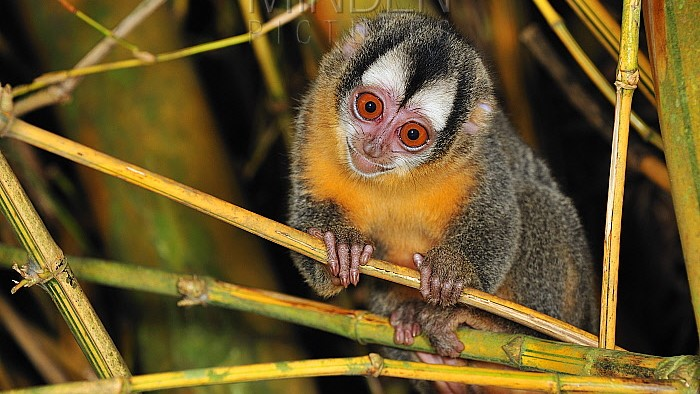

In [262]:
from IPython.display import Image

image_name = 'n8013.jpg'
Image(image_path+image_name)

In [263]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np

img_path = os.path.join(image_path, image_name)
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 299, 299, 3)


In [264]:
pred = model.predict(x)
print('Predicted:', pred)

print(np.argmax(pred))

Predicted: [[9.2277740e-05 9.3119033e-06 9.5769780e-04 8.8287934e-06 3.1928632e-06
  8.7360979e-07 1.1972535e-05 3.8037320e-05 9.9887532e-01 2.4760384e-06]]
8


In [267]:
result= np.argmax(pred)
if result==0:
    print("Its a alouatta")
elif result==1:
    print("Its a erthro")
elif result==2:
    print("Its a cacaujao")
elif result==3:
    print("Its a macaca")
elif result==4:
    print("Its a cebeuella")
   
elif result==5:
    print("Its a cebus")
elif result==6:
    print("Its a mico")
elif result==7:
    print("Its a saimiri")
elif result==8:
    print("Its a aotus")
elif result==9:
    print("Its a trachy")
 

Its a aotus


In [266]:
#names

['alouatta',
 'erythro',
 'cacaujao',
 'macaca',
 'cebeuella',
 'cebus',
 'mico',
 'saimiri',
 'aotus',
 'trachy']

## Saving the model and weights back to local machine

In [0]:
# Downloading from colab to local machine

from google.colab import files

files.download('monkeys2.h5')  

In [0]:
files.download('monkeys2_weights.h5') 

### If you need to kill the VM and restart Colab with a new machine

In [0]:
!kill -9 -1